In [29]:
## 1. 유튜브 댓글 크롤링

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
from openpyxl import Workbook

## 크롬창에서 입력한 url로 이동하여 댓글을 추출 하는 함수
# 순서: 크롬창 띄우기 -> url로 이동 -> 해당 url의 하단으로 스크롤(유튜브 댓글이 해당 페이지의 하단에 있기 때문)
#      -> 댓글 요소 탐색 -> 추출 -> 아래로 스크롤 -> 추가로 로드 된 댓글 확인 -- 이 4가지 작업 반복
#      -> 스크롤을 해도 추가 로드 된 댓글이 없으면 stop

def crawl_youtube_comments(url):
    
    # Chrome 웹 드라이버 실행
    driver = webdriver.Chrome()
    # 유튜브 댓글 페이지 열기
    driver.get(url)
    # 페이지가 로드될 때까지 잠시 대기
    time.sleep(6)
    
    # 스크롤을 내려 더 많은 댓글을 로드
    body = driver.find_element(By.TAG_NAME, 'body')
    while True:
        # 현재 댓글 수
        current_comments = len(driver.find_elements(By.CSS_SELECTOR, "#content-text"))
        # 페이지 스크롤 다운
        body.send_keys(Keys.END)
        time.sleep(4)  # 스크롤 후 페이지가 로드될 때까지 대기
        # 새로 로드된 댓글 수
        new_comments = len(driver.find_elements(By.CSS_SELECTOR, "#content-text"))
        # 댓글이 더 이상 로드되지 않으면 종료
        if new_comments == current_comments:
            break
        print(f"댓글 수: {new_comments}")
        
    # 댓글 요소들 찾기
    comment_elements = driver.find_elements(By.CSS_SELECTOR, "#content-text")
    comments = []
    # 댓글 텍스트 추출
    for comment in comment_elements:
        comments.append(comment.text)
        # 답글 찾기
        parent_element = comment.find_element(By.XPATH, "..")
        replies = parent_element.find_elements(By.XPATH, ".//yt-formatted-string[@id='content-text']")
        for reply in replies:
            comments.append("답글: " + reply.text)
    # 크롬 드라이버 종료
    driver.quit()
    return comments



## 추출한 댓글 저장(excel) 함수
def save_to_excel(comments, filename):
    # 엑셀 워크북 생성
    wb = Workbook()
    ws = wb.active
    ws.append(["댓글"])
    # 댓글을 엑셀에 쓰기
    for i, comment in enumerate(comments, start=1):
        ws.append([comment])
        print(f"\r댓글 저장 중... ({i}/{len(comments)})", end="")
    # 엑셀 파일 저장
    wb.save(filename)
    print("\n댓글이 성공적으로 저장되었습니다.")


## 탐색할 url의 주소와 저장 파일명 입력 및 함수 실행
if __name__ == "__main__":
    # 유튜브 동영상 URL
    youtube_url = input("url 입력하세요.")
    file_name = input('저장할 파일명을 입력하세요: ')+'.xlsx'

    # 크롤링할 댓글
    comments = crawl_youtube_comments(youtube_url)
    # 엑셀 파일로 저장
    save_to_excel(comments, file_name)

url 입력하세요. https://www.youtube.com/watch?v=LYwk8cCzMyM
저장할 파일명을 입력하세요:  test


댓글 수: 40
댓글 수: 60
댓글 수: 80
댓글 수: 87
댓글 저장 중... (87/87)
댓글이 성공적으로 저장되었습니다.


In [20]:
## 2. 크롤링 파일 불러 오기 및 전처리
# 결측치, 중복 데이터 제거
# 문장 split

import pandas as pd
from transformers import pipeline


# 데이터 불러오기
file_path = "C:/Users/Hong/snsmarketing/data/gal_s24_com_1-50.xlsx"
s24 = pd.read_excel(file_path)
print(f'유튜브 댓글의 전체 갯수: {len(s24)}')

# 결측치 및 중복 데이터 제거
print(f'결측치 갯수 확인: {s24.isnull().sum()}')
s24.dropna(inplace=True)
print(f'중복치 갯수 확인: {s24.duplicated().sum()}')
s24.drop_duplicates(inplace=True)
print(f'결측치 및 중복 데이터 제거 후 데이터의 길이: {len(s24)}')


# \n으로 구분된 댓글을 각각의 행으로 분할
s24['댓글'] = s24['댓글'].str.split('\n')
s24 = s24.explode('댓글').reset_index(drop=True)


# 마침표로 구분된 문장을 각각의 행으로 분할, 마침표만 남게 되는 행은 삭제
s24['댓글'] = s24['댓글'].str.split('.')
s24 = s24.explode('댓글').reset_index(drop=True)
s24['댓글'] = s24['댓글'].str.strip()
s24 = s24[s24['댓글'] != ''].reset_index(drop=True)


# 결과 출력
display(s24)

'''
# 결과를 엑셀 파일로 저장
output_file_path = "C:/Users/Hong/snsmarketing/data/s24.xlsx"
s24.to_excel(output_file_path, index=False)
print("Excel 파일이 성공적으로 저장되었습니다:", output_file_path)
'''

유튜브 댓글의 전체 갯수: 13782
결측치 갯수 확인: 댓글    46
dtype: int64
중복치 갯수 확인: 252
결측치 및 중복 데이터 제거 후 데이터의 길이: 13484


,댓글
0,아무리 기본 S모델이라지만 가격이 절대 저렴하지 않은데 램8기가 넣은 건 진짜 실망...
1,그래도 여러가지 항목으로 나눠서 정리해 주니까 한눈에 보기 편하네요
2,요런 리뷰 좋습니다
3,비교분석 감사드립니다
4,항상 잘보고 있어요!
...,...
24636,와 삼성이 이렇게 진심으로 삼성을 좋아하는 사람한테 대하는 태도가 참
24637,쓴소리 몇마디했다고 차별하는게 마치 중국스럽네요
24638,한마디로 꼴불견이네요
24639,정떨어져서 담에는 애플로 넘어가야겠어요 ㅎㅎ


'\n# 결과를 엑셀 파일로 저장\noutput_file_path = "C:/Users/Hong/snsmarketing/data/s24.xlsx"\ns24.to_excel(output_file_path, index=False)\nprint("Excel 파일이 성공적으로 저장되었습니다:", output_file_path)\n'

In [ ]:
## 3. 감성 분석 실행 및 저장
# 감성 분석을 위해 파이프라인 모델 로드
model_name = 'snunlp/KR-FinBert-SC'
kor_finbert = pipeline(model=model_name)

# 텍스트 데이터 생성
text = s24['댓글'].tolist()

# 감성 분석 실행
result = kor_finbert(text)

# 감성 분석 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(result)

# 원본 데이터와 감성 분석 결과를 합침
s24['label'] = result_df['label']
s24['score'] = result_df['score']

display(s24)

'''
# 감성 분석 결과를 엑셀 파일로 저장
output_file_path = "C:/Users/Hong/snsmarketing/data/s24_finbert.xlsx"
s24.to_excel(output_file_path, index=False)
print("감성 분석 결과가 포함된 Excel 파일이 성공적으로 저장되었습니다:", output_file_path)
'''

각 라벨의 빈도수:
label
neutral     22571
negative     1045
positive     1025
Name: count, dtype: int64


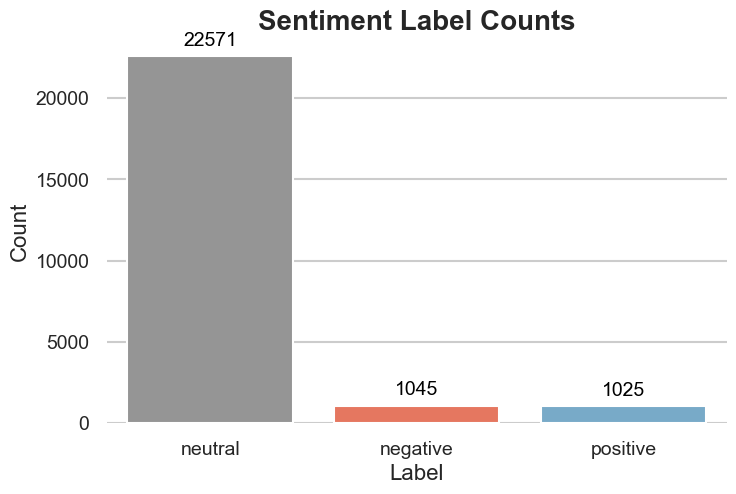

In [21]:
## 4. 감성 분석 결과 시각화 - 빈도수 확인

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 엑셀 파일로부터 데이터프레임으로 불러오기
file_path = "C:/Users/Hong/snsmarketing/data/s24_finbert.xlsx"
s24 = pd.read_excel(file_path)

# 각 라벨의 빈도수를 계산
label_counts = s24['label'].value_counts()

# 빈도수 출력
print("각 라벨의 빈도수:")
print(label_counts)

# 빈도수를 데이터프레임으로 변환
label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['label', 'count']

# Seaborn 스타일 설정
sns.set(style="whitegrid", context="talk")

# 색상 팔레트 설정 (부정: 붉은색, 긍정: 푸른색, 중립: 옅은 회색)
palette = {
    'negative': sns.color_palette("Reds", 3)[1],  # 중간 톤의 빨간색
    'positive': sns.color_palette("Blues", 3)[1],  # 중간 톤의 파란색
    'neutral': sns.color_palette("Greys", 3)[1]   # 중간 톤의 회색
}

# 시각화 설정 (전체 라벨)
plt.figure(figsize=(8, 5))  # 그래프 크기 조정
ax = sns.barplot(x='label', y='count', hue='label', data=label_counts_df, palette=palette, dodge=False, legend=False)

# 막대 그래프 위에 빈도수 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=14, color='black', xytext=(0, 8), textcoords='offset points')

# 제목 및 라벨 설정
plt.title('Sentiment Label Counts', fontsize=20, fontweight='bold')
plt.xlabel('Label', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# 그래프 테마 설정
sns.despine(left=True, bottom=True)

# 그래프 출력
plt.show()

In [22]:
## 5. 감성분석을 마친 데이터에서 레이블이 neutral인 데이터 삭제

file_path = "C:/Users/Hong/snsmarketing/data/s24_finbert.xlsx"
s24 = pd.read_excel(file_path)
display(s24)
print(type(s24))

print("데이터프레임 구조:")
print(s24.info())

s24 = s24[s24['label'] != 'neutral']
s24.sort_values(by='label', inplace=True)
s24.reset_index(drop=True, inplace=True)
display(s24)

output_file_path = "C:/Users/Hong/snsmarketing/data/s24_finbert_noneu.xlsx"
s24.to_excel(output_file_path, index=False)
print("감성 분석 결과가 포함된 Excel 파일이 성공적으로 저장되었습니다:", output_file_path)

,댓글,label,score
0,아무리 기본 S모델이라지만 가격이 절대 저렴하지 않은데 램8기가 넣은 건 진짜 실망...,neutral,0.876683
1,그래도 여러가지 항목으로 나눠서 정리해 주니까 한눈에 보기 편하네요,neutral,0.999121
2,요런 리뷰 좋습니다,neutral,0.999890
3,비교분석 감사드립니다,neutral,0.819777
4,항상 잘보고 있어요!,neutral,0.998734
...,...,...,...
24636,와 삼성이 이렇게 진심으로 삼성을 좋아하는 사람한테 대하는 태도가 참,neutral,0.942464
24637,쓴소리 몇마디했다고 차별하는게 마치 중국스럽네요,neutral,0.814042
24638,한마디로 꼴불견이네요,neutral,0.781010
24639,정떨어져서 담에는 애플로 넘어가야겠어요 ㅎㅎ,neutral,0.943827


<class 'pandas.core.frame.DataFrame'>
데이터프레임 구조:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24641 entries, 0 to 24640
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   댓글      24640 non-null  object 
 1   label   24641 non-null  object 
 2   score   24641 non-null  float64
dtypes: float64(1), object(2)
memory usage: 577.6+ KB
None


,댓글,label,score
0,이게 저화질 플리커 현상 때문이었구나,negative,0.893545
1,역시 폴드4는 제외 군요 또륵,negative,0.595987
2,S22 쓰는데 진심 이때까지 썼던 폰들 중에 최악이에요,negative,0.976142
3,노트9은 버린 자식인가요?,negative,0.806122
4,"요즘은 노트북도 기본 5년은 쓰는데, 노트북 보다 비싼 폰을 2년짜리 취급을 하니 ...",negative,0.457106
...,...,...,...
2065,이제는 점유율마저 아이폰에 내줬다고 하던데 다시 탈환해 올 수 있을까,positive,0.506111
2066,아이폰이나 갤럭시나 하드웨어 완성도는 진짜 극에 달했네요,positive,0.492461
2067,그에 비해 울트라는 다른 스마트폰과 확실한 차별성으로부터 비롯된 유니크함과 소재의 ...,positive,0.996128
2068,갠적으로 화면은 노트10 6,positive,0.985767


감성 분석 결과가 포함된 Excel 파일이 성공적으로 저장되었습니다: C:/Users/Hong/snsmarketing/data/s24_finbert_noneu.xlsx


In [ ]:
## 6. 형태소 분석(Kkma)

import pandas as pd
from konlpy.tag import Kkma
from tqdm import tqdm

# 파일 경로 설정
file_path = "C:/Users/Hong/snsmarketing/data/s24_finbert_noneu.xlsx"

# 데이터 불러오기
s24 = pd.read_excel(file_path)

# Kkma 객체 생성
kkma = Kkma()

# 형태소 분석 함수 정의
def analyze_comment(comment):
    return kkma.morphs(comment)

# tqdm을 사용하여 진행률 표시
tqdm.pandas()

# 각 행에 대해 형태소 분석 적용하여 '댓글_형태소' 열에 추가
s24['댓글_형태소'] = s24['댓글'].progress_apply(lambda x: analyze_comment(x) if pd.notnull(x) else [])

# 결과 출력
display(s24)

'''
# 결과를 엑셀 파일로 저장
output_file_path = "C:/Users/Hong/snsmarketing/data/s24_Kkma.xlsx"
s24.to_excel(output_file_path, index=False)
print("감성 분석 결과가 포함된 Excel 파일이 성공적으로 저장되었습니다:", output_file_path)
'''

In [23]:
## 7. 불용어 제거
# 10번 단계에서 시각화 된 자료를 바탕으로 불용어 사전 추가
# (탐색과 전처리) 반복 작업을 통해 적합한 형태소 탐색

import string
import pandas as pd
import ast

# 엑셀 파일로부터 데이터프레임으로 불러오기
s24 = pd.read_excel("C:/Users/Hong/snsmarketing/data/s24_Kkma.xlsx")

# '댓글_형태소' 열의 각 행을 리스트로 인식하여 데이터프레임으로 변환
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        print(f"Error parsing: {val}")
        return []

s24['댓글_형태소'] = s24['댓글_형태소'].apply(safe_literal_eval)

# 불용어 사전 텍스트 파일 불러오기
stopwords_kor_path = "C:/Users/Hong/snsmarketing/data/stopwords.txt" 
stopwords_s24_path = "C:/Users/Hong/snsmarketing/data/stopwords_s24.txt"

with open(stopwords_kor_path, 'r', encoding='utf-8') as file:
    stopwords_kor = file.read().splitlines()

with open(stopwords_s24_path, 'r', encoding='utf-8') as file:
    stopwords_s24 = file.read().splitlines()

word_list = stopwords_kor + stopwords_s24
word_list.extend(list(string.punctuation))

# '댓글_형태소_불용어제거' 열 초기화 및 불용어 처리
def remove_stopwords(tokens, stopwords):
    return [word for word in tokens if word not in stopwords]

s24['댓글_형태소_불용어제거'] = s24['댓글_형태소'].apply(lambda x: remove_stopwords(x, word_list))

# 결과 확인
display(s24['댓글_형태소_불용어제거'])

# 결과를 엑셀 파일로 저장 (필요한 경우)
output_file_path = "C:/Users/Hong/snsmarketing/data/s24_Kkma_clean.xlsx"
s24.to_excel(output_file_path, index=False)
print("감성 분석 결과가 포함된 Excel 파일이 성공적으로 저장되었습니다:", output_file_path)

0                                       [화질, 플리커, 때문, 구나]
1                                             [역시, 제외, 륵]
2                                                [진심, 최악]
3                                                 [9, 자식]
4                [요즘, 노트북, 기본, 노트북, 비싸, 짜리, 취급, 답, 라는, 드]
                              ...                        
2065                                    [점유율, 내주, 탈환, 을까]
2066                                   [하드웨어, 완성도, 극, 달하]
2067    [비하, 확실, 차별성, 유니크함, 소재, 고급, 섞이, 확실히, 라는, ㄴ다는, ...
2068                                                 [화면]
2069    [듣, 인공지능, 비서, 빅, 스비, 연동, 편리, 음성, 명령, 가능, 해지, 보...
Name: 댓글_형태소_불용어제거, Length: 2070, dtype: object

감성 분석 결과가 포함된 Excel 파일이 성공적으로 저장되었습니다: C:/Users/Hong/snsmarketing/data/s24_Kkma_clean.xlsx


In [24]:
## 8. positive - negative 데이터 분리 작업
s24_positive = s24[s24['label'] == 'positive'].reset_index(drop=True)
s24_negative = s24[s24['label'] == 'negative'].reset_index(drop=True)

print("Positive DataFrame:")
display(s24_positive)
print("\nNegative DataFrame:")
display(s24_negative)

Positive DataFrame:


,댓글,label,score,댓글_형태소,댓글_형태소_불용어제거
0,대박ㅎ,positive,0.847126,"[대박, ㅎ]","[대박, ㅎ]"
1,현재 국내에 판매되고 있는 삼성 모바일의 경우 '보상판매'의 기간제를 두고 있지만 ...,positive,0.394191,"[현재, 국내, 에, 판매, 되, 고, 있, 는, 삼성, 모바일, 의, 경우, ',...","[현재, 판매, 모바일, 경우, 보상, 판매, 기간, 두, 미국, 법인, 경우, 기..."
2,갤 편의성,positive,0.705969,"[개, ㄹ, 편의성]",[편의성]
3,현기차도 차별하더만 삼성전자도 차별하네,positive,0.883947,"[현기, 차도, 차별하더, 만, 삼성전자, 도, 차별, 하, 네]","[현기, 차도, 차별하더, 삼성전자, 차별]"
4,컴퓨터기초 및 스마트폰 사용법 IT 기기 엑셀 프리젠테이션 한글 문서작성,positive,0.620704,"[컴퓨터, 기초, 및, 스마트, 폰, 사용법, IT, 기기, 엑셀, 프리젠테이션, ...","[컴퓨터, 기초, 사용법, IT, 기기, 엑셀, 프리젠테이션, 한글, 문서, 작성]"
...,...,...,...,...,...
1020,이제는 점유율마저 아이폰에 내줬다고 하던데 다시 탈환해 올 수 있을까,positive,0.506111,"[이제, 는, 점유율, 마저, 아이, 폰, 에, 내주, 었, 다고, 하, 던데, 다...","[점유율, 내주, 탈환, 을까]"
1021,아이폰이나 갤럭시나 하드웨어 완성도는 진짜 극에 달했네요,positive,0.492461,"[아이, 폰, 이나, 갤럭시, 나, 하드웨어, 완성도, 는, 진짜, 극, 에, 달하...","[하드웨어, 완성도, 극, 달하]"
1022,그에 비해 울트라는 다른 스마트폰과 확실한 차별성으로부터 비롯된 유니크함과 소재의 ...,positive,0.996128,"[그, 에, 비하, 어, 울트라, 는, 다른, 스마트, 폰, 과, 확실, 하, ㄴ,...","[비하, 확실, 차별성, 유니크함, 소재, 고급, 섞이, 확실히, 라는, ㄴ다는, ..."
1023,갠적으로 화면은 노트10 6,positive,0.985767,"[개, ㄴ, 적, 으로, 화면, 은, 노트, 10, 6]",[화면]



Negative DataFrame:


,댓글,label,score,댓글_형태소,댓글_형태소_불용어제거
0,이게 저화질 플리커 현상 때문이었구나,negative,0.893545,"[이것, 이, 저, 어, 화질, 플리커, 현상, 때문, 이, 었, 구나]","[화질, 플리커, 때문, 구나]"
1,역시 폴드4는 제외 군요 또륵,negative,0.595987,"[역시, 폴드, 4, 는, 제외, 군, 요, 또, 륵]","[역시, 제외, 륵]"
2,S22 쓰는데 진심 이때까지 썼던 폰들 중에 최악이에요,negative,0.976142,"[S, 22, 쓰, 는데, 진심, 이때, 까지, 쓰, 었, 더, ㄴ, 폰, 들, 중...","[진심, 최악]"
3,노트9은 버린 자식인가요?,negative,0.806122,"[노트, 9, 은, 버리, ㄴ, 자식, 이, ㄴ가요, ?]","[9, 자식]"
4,"요즘은 노트북도 기본 5년은 쓰는데, 노트북 보다 비싼 폰을 2년짜리 취급을 하니 ...",negative,0.457106,"[요즘, 은, 노트북, 도, 기본, 5, 년, 은, 쓰, 는데, ,, 노트북, 보다...","[요즘, 노트북, 기본, 노트북, 비싸, 짜리, 취급, 답, 라는, 드]"
...,...,...,...,...,...
1040,노트 20 울트라부터 손목이 단련이 되었는지 크게 불만은 없고,negative,0.908158,"[노트, 20, 울트라, 부터, 손목, 이, 단련, 이, 되, 었, 는지, 크, 게...","[손목, 단련, 불만]"
1041,"아니, 예상된 판매량을 기대할 수 있다면 어느정도의 문제는 그냥 무시하고 출시부터한...",negative,0.433647,"[알, 니, ,, 예상, 되, ㄴ, 판매량, 을, 기대, 하, ㄹ, 수, 있, 다면...","[예상, 판매량, 기대, 다면, 정도, 문제, 무시, ㄴ다는, 마인드]"
1042,4:45 폰도 12기가램인데 M3맥북프로는 왜 8기가냐고ㅋㅋㅋㅋㅋㅋ,negative,0.616516,"[4, :, 45, 폰, 도, 12, 기가, 램, 이, ㄴ데, M, 3, 맥, 북,...","[45, 램, M, 맥, 북, ㅋㅋㅋㅋㅋㅋ]"
1043,"울트라 잘못은 전혀아니지만, 네임드 게임 몇개 팅깁니다",negative,0.983595,"[울트라, 잘못, 은, 전혀, 아니, 지만, ,, 네, 임드, 게임, 몇, 개, 팅...","[잘못, 전혀, 임드, 게임, 팅, 길]"


In [25]:
## 9. positive - negative 각 데이터 별 형태소 빈도수 계산

import pandas as pd
from collections import Counter

# '댓글_형태소_불용어제거' 열에서 형태소 리스트 추출 및 빈도수 계산
def calculate_morph_frequencies(df):
    # 리스트 형식인지 확인
    def check_data_type(row):
        return isinstance(row, list)
    
    df['is_list'] = df['댓글_형태소_불용어제거'].apply(check_data_type)
    
    if not df['is_list'].all():
        print("Some rows are not lists")
        # 리스트가 아닌 행을 빈 리스트로 변환
        df['댓글_형태소_불용어제거'] = df['댓글_형태소_불용어제거'].apply(lambda x: x if isinstance(x, list) else [])
    
    # 리스트의 리스트를 평탄화하고 형태소 빈도수 계산
    morphs_flat = [item for sublist in df['댓글_형태소_불용어제거'] for item in sublist]
    morphs_counter = Counter(morphs_flat)
    
    # 결과를 데이터프레임으로 변환 및 정렬
    mor_freq = pd.DataFrame(morphs_counter.items(), columns=['형태소', '빈도수']).sort_values(by='빈도수', ascending=False)
    return mor_freq

# 형태소 빈도수 계산
mor_freq_positive = calculate_morph_frequencies(s24_positive)
mor_freq_negative = calculate_morph_frequencies(s24_negative)

# 결과 출력
display(mor_freq_positive)
display(mor_freq_negative)

# 결과를 엑셀 파일로 저장
output_file_path = 'C:/Users/Hong/snsmarketing/data/mor_freq_positive.xlsx'
mor_freq_positive.to_excel(output_file_path, index=False)
output_file_path = 'C:/Users/Hong/snsmarketing/data/mor_freq_negative.xlsx'
mor_freq_negative.to_excel(output_file_path, index=False)
print("형태소 빈도수가 포함된 Excel 파일이 성공적으로 저장되었습니다:", output_file_path)

,형태소,빈도수
331,AI,90
118,기대,87
49,기능,68
42,성능,68
272,램,58
...,...,...
1072,도입,1
1069,기호,1
1067,담기,1
1066,철학,1


,형태소,빈도수
252,문제,55
257,불량,49
83,실망,46
473,카메라,41
235,애플,40
...,...,...
1288,ㄹ라고,1
1286,글로벌,1
1285,이란,1
1280,깍,1


형태소 빈도수가 포함된 Excel 파일이 성공적으로 저장되었습니다: C:/Users/Hong/snsmarketing/data/mor_freq_negative.xlsx


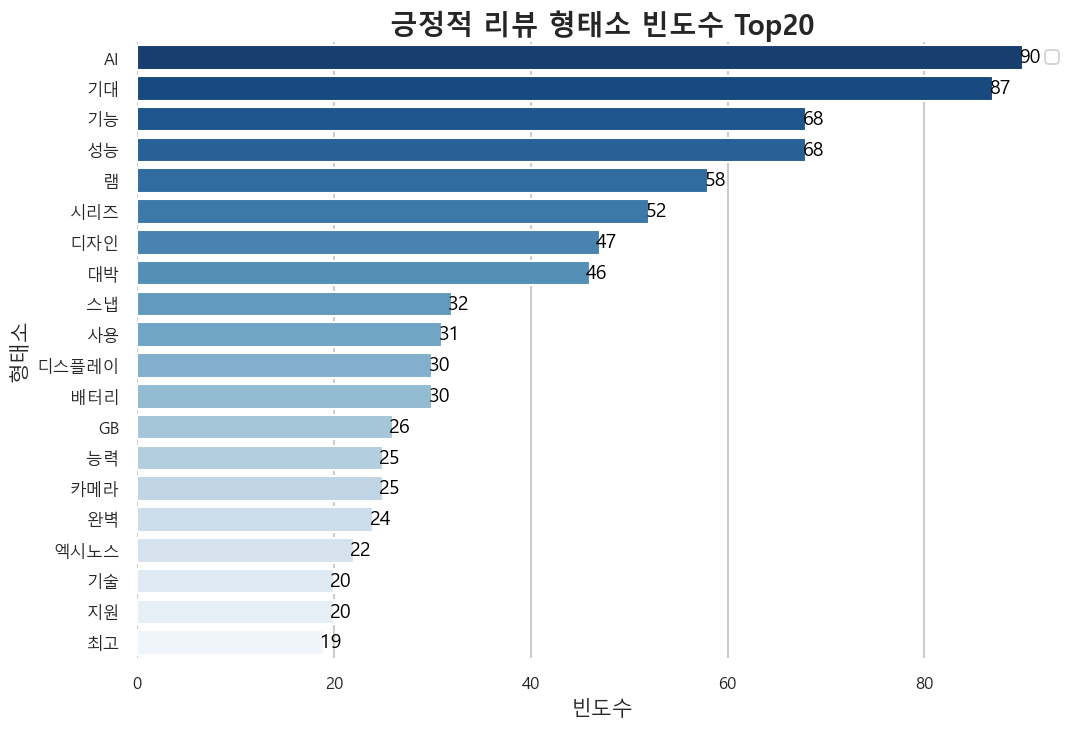

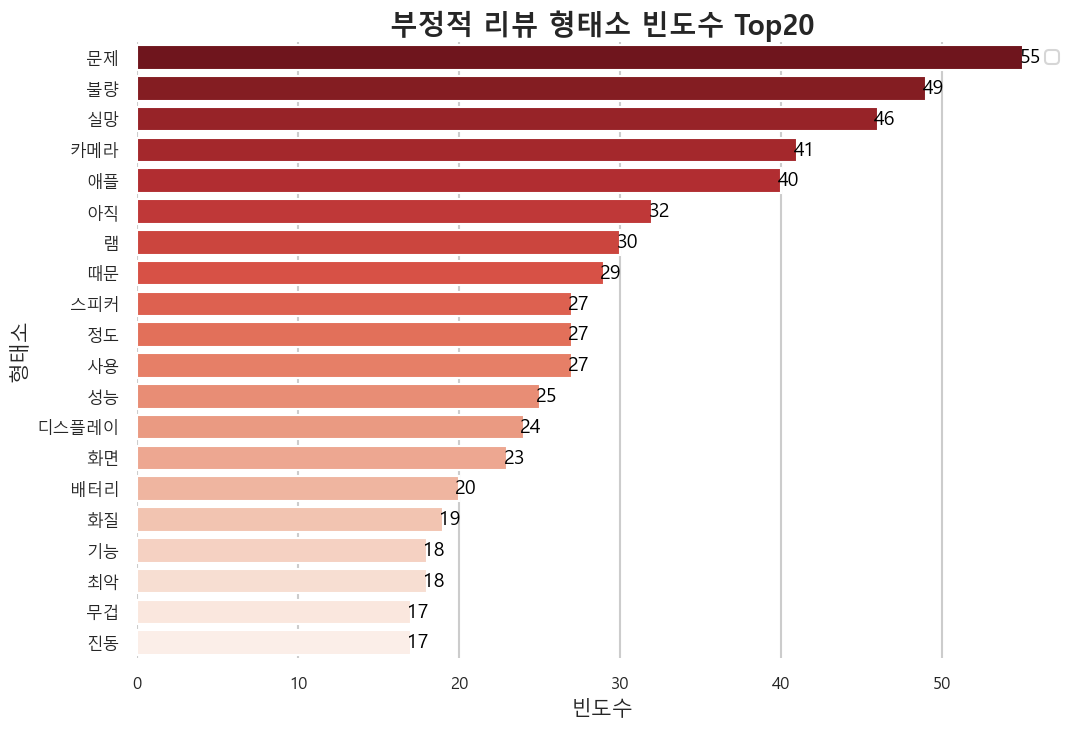

In [27]:
## 10. 데이터 시각화(1) - 각 데이터의 막대 그래프

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import matplotlib as mpl
import platform
import pandas as pd

# 데이터 불러오기
file_path_positive = 'C:/Users/Hong/snsmarketing/data/mor_freq_positive.xlsx'
positive_mor_freq = pd.read_excel(file_path_positive)

file_path_negative = 'C:/Users/Hong/snsmarketing/data/mor_freq_negative.xlsx'
negative_mor_freq = pd.read_excel(file_path_negative)

# 그래프에 한글 깨짐 현상 해결
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':  # Mac
    rc('font', family='AppleGothic')
else:
    rc('font', family='NanumGothic')

mpl.rcParams['axes.unicode_minus'] = False

# 상위 20개의 형태소 빈도수 시각화 함수 정의
def plot_morph_frequencies(mor_freq, title, palette_base):
    mor_freq = mor_freq.head(20)
    gradient_palette = sns.color_palette(palette_base, len(mor_freq))[::-1]  # 팔레트를 반전시킴

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='빈도수', y='형태소', hue='형태소', data=mor_freq, palette=gradient_palette, dodge=False, legend=False)
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel('빈도수', fontsize=15)
    plt.ylabel('형태소', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine(left=True, bottom=True)  # 그래프 테두리 제거

    # 막대 그래프 위에 빈도수 표시
    for p in ax.patches:
        ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha='center', va='center', fontsize=14, color='black', xytext=(5, 0), textcoords='offset points')

    # 범례 추가 및 색상 설정
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels, loc='best', fontsize=12)
    for text in legend.get_texts():
        text.set_color("gray")

    plt.show()

# Positive 데이터 시각화 (파란색 계열)
plot_morph_frequencies(positive_mor_freq, '긍정적 리뷰 형태소 빈도수 Top20', 'Blues')

# Negative 데이터 시각화 (붉은색 계열)
plot_morph_frequencies(negative_mor_freq, '부정적 리뷰 형태소 빈도수 Top20', 'Reds')

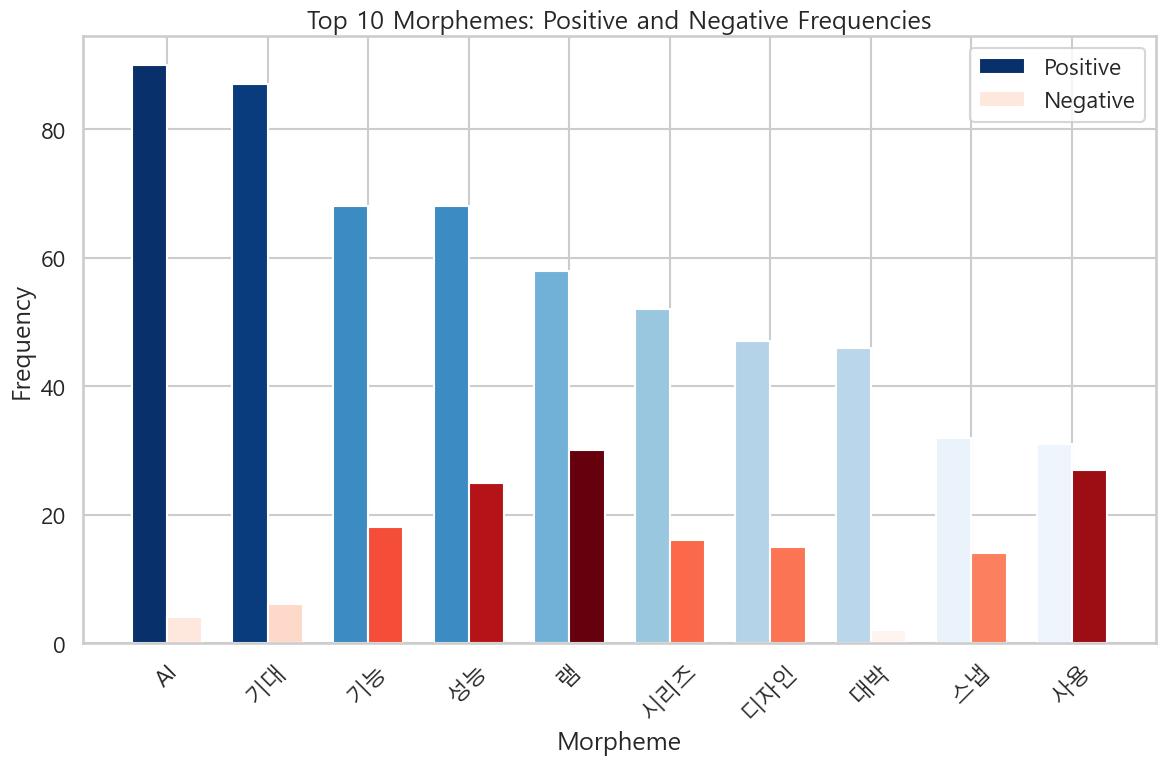

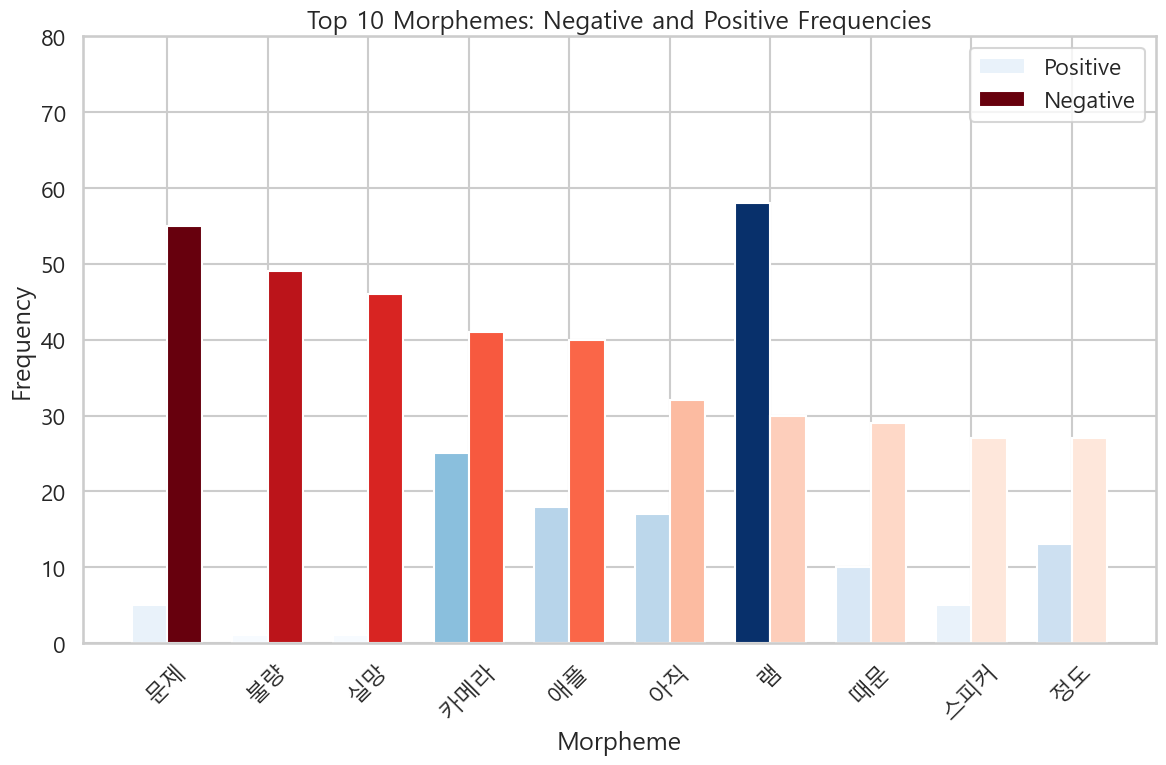

In [496]:
## 10. 데이터 시각화(2) - 각 데이터별 top10형태소의 빈도수 시각화(in 긍정+부정)
# 같은 키워드, 상반된 의견의 비율 확인용

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기
file_path_positive = 'C:/Users/Hong/snsmarketing/data/mor_freq_positive.xlsx'
positive_mor_freq = pd.read_excel(file_path_positive)

file_path_negative = 'C:/Users/Hong/snsmarketing/data/mor_freq_negative.xlsx'
negative_mor_freq = pd.read_excel(file_path_negative)


# 긍정 top10 형태소 추출
top10_positive = positive_mor_freq.head(10)

# positive와 negative의 빈도수 합치기
merged_freq = pd.merge(top10_positive, negative_mor_freq, on='형태소', suffixes=('_positive', '_negative'))

# 빈도수에 따라 색상 결정 함수
def get_color_gradient(frequencies, cmap_name):
    norm = plt.Normalize(frequencies.min() * 0.9, frequencies.max())  # 최소값의 80%로 정규화 범위 조정
    cmap = plt.get_cmap(cmap_name)
    return [cmap(norm(value)) for value in frequencies]

# 그래프 그리기(긍정 형태소 top10 in 긍정+부정)
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(merged_freq))

positive_colors = get_color_gradient(merged_freq['빈도수_positive'], 'Blues')
negative_colors = get_color_gradient(merged_freq['빈도수_negative'], 'Reds')

plt.bar(index, merged_freq['빈도수_positive'], bar_width, label='Positive', color=positive_colors)
plt.bar(index + bar_width, merged_freq['빈도수_negative'], bar_width, label='Negative', color=negative_colors)

plt.xlabel('Morpheme')
plt.ylabel('Frequency')
plt.title('Top 10 Morphemes: Positive and Negative Frequencies')
plt.xticks(index + bar_width / 2, merged_freq['형태소'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

print('='*200)

# 부정 top10 형태소 추출
top10_negative = negative_mor_freq.head(10)

# positive와 negative의 빈도수 합치기 (부정 top10 기준)
merged_freq_negative = pd.merge(top10_negative, positive_mor_freq, on='형태소', suffixes=('_negative', '_positive'))

# 그래프 그리기(부정 형태소 top10 in 긍정+부정)
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(merged_freq_negative))

positive_colors = get_color_gradient(merged_freq_negative['빈도수_positive'], 'Blues')
negative_colors = get_color_gradient(merged_freq_negative['빈도수_negative'], 'Reds')

plt.bar(index, merged_freq_negative['빈도수_positive'], bar_width, label='Positive', color=positive_colors)
plt.bar(index + bar_width, merged_freq_negative['빈도수_negative'], bar_width, label='Negative', color=negative_colors)

plt.xlabel('Morpheme')
plt.ylabel('Frequency')
plt.ylim(0, 80)  # y축 범위 설정
plt.title('Top 10 Morphemes: Negative and Positive Frequencies')
plt.xticks(index + bar_width / 2, merged_freq_negative['형태소'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

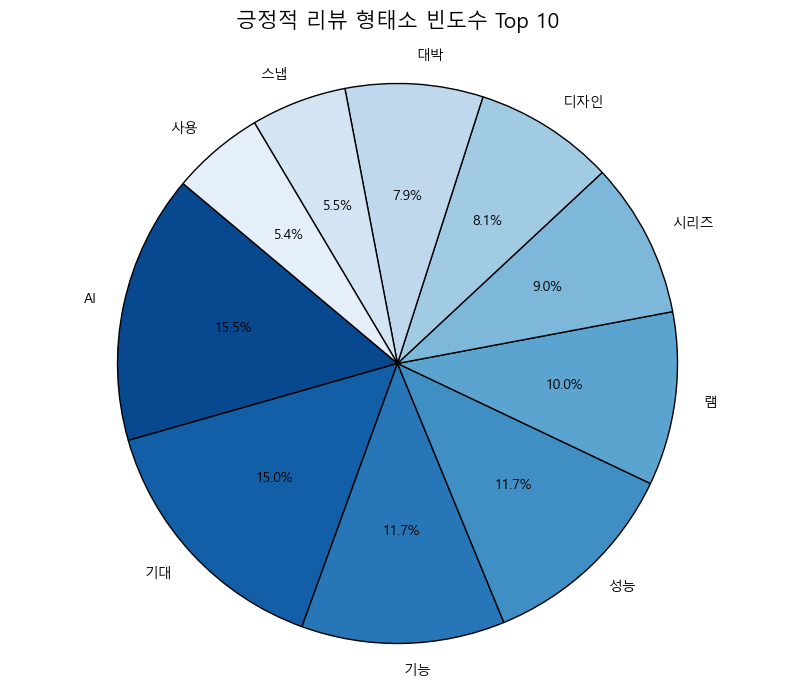

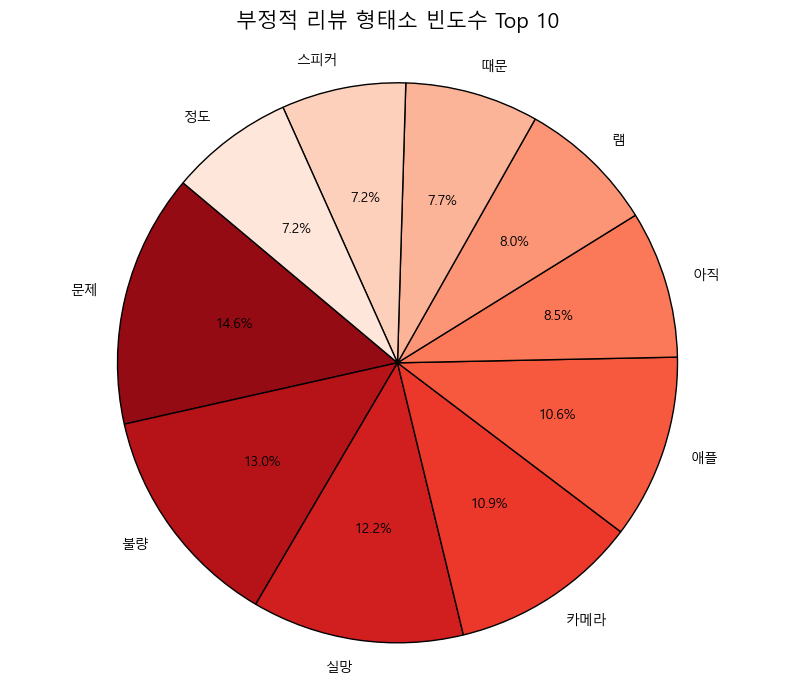

In [14]:
## 10. 데이터 시각화(3) - 파이 차트

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import matplotlib as mpl
import platform
import pandas as pd

# 데이터 불러오기
file_path = 'C:/Users/Hong/snsmarketing/data/mor_freq_positive.xlsx'
positive_mor_freq = pd.read_excel(file_path)

file_path = 'C:/Users/Hong/snsmarketing/data/mor_freq_negative.xlsx'
negative_mor_freq = pd.read_excel(file_path)

# 그래프에 한글 깨짐 현상 해결
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':  # Mac
    rc('font', family='AppleGothic')
else:
    rc('font', family='NanumGothic')

mpl.rcParams['axes.unicode_minus'] = False

# 파이 차트 함수 정의
def plot_pie_chart(freq, title, palette):
    freq_top10 = freq.head(10)  # 상위 10개 추출
    plt.figure(figsize=(10, 8))
    
    # 빈도수에 따라 그라데이션 색상 적용
    colors = sns.color_palette(palette, len(freq_top10))
    colors = colors[::-1]  # 빈도수 높은 것을 진하게 하기 위해 순서 반전

    plt.pie(freq_top10['빈도수'], labels=freq_top10['형태소'], autopct='%1.1f%%', startangle=140, 
            colors=colors, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title, fontsize=15, pad=20)  # pad 값을 통해 제목과 차트 사이 간격 조절
    plt.show()

# 리뷰 형태소 빈도수 시각화
plot_pie_chart(positive_mor_freq, '긍정적 리뷰 형태소 빈도수 Top 10', 'Blues')
plot_pie_chart(negative_mor_freq, '부정적 리뷰 형태소 빈도수 Top 10', 'Reds')

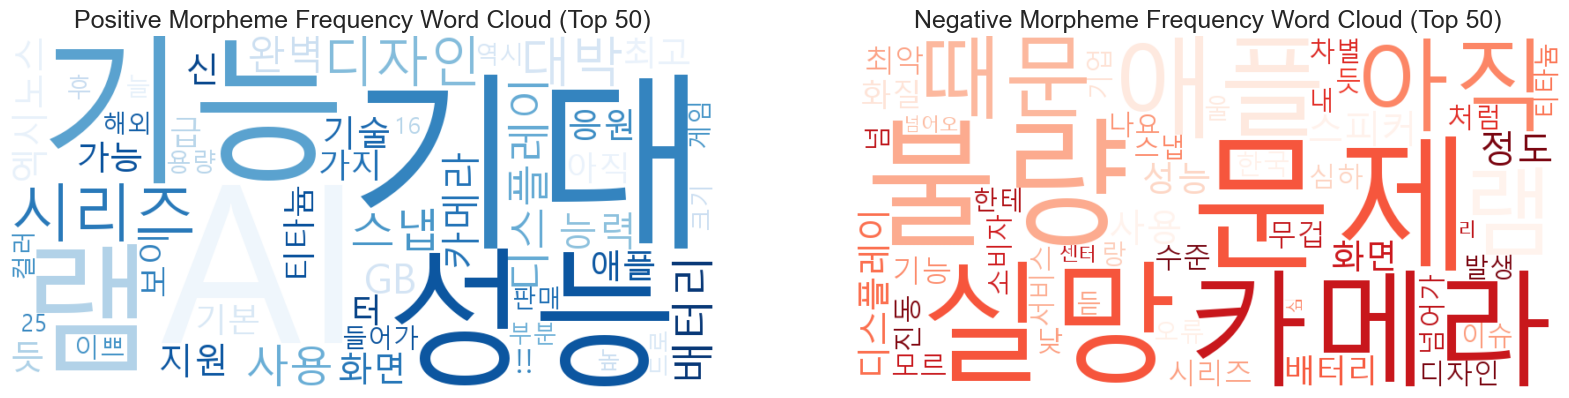

In [21]:
## 10. 데이터 시각화(4) - WordCloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# 데이터 불러오기
file_path = 'C:/Users/Hong/snsmarketing/data/mor_freq_positive.xlsx'
positive_mor_freq = pd.read_excel(file_path)

file_path = 'C:/Users/Hong/snsmarketing/data/mor_freq_negative.xlsx'
negative_mor_freq = pd.read_excel(file_path)


# 상위 10개 형태소만 선택
positive_top10 = positive_mor_freq.nlargest(50, '빈도수')
negative_top10 = negative_mor_freq.nlargest(50, '빈도수')

# 워드클라우드 생성
wordcloud_positive = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf", width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(dict(zip(positive_top10['형태소'], positive_top10['빈도수'])))
wordcloud_negative = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf", width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(dict(zip(negative_top10['형태소'], negative_top10['빈도수'])))

# 워드클라우드 시각화
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Morpheme Frequency Word Cloud (Top 50)')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Morpheme Frequency Word Cloud (Top 50)')

plt.show()

In [28]:
## 11. 빈도수가 높은 형태소를 포함한 문장 추출

import pandas as pd

# 데이터 불러오기
file_path_pos = 'C:/Users/Hong/snsmarketing/data/mor_freq_positive.xlsx'
positive_mor_freq = pd.read_excel(file_path_pos)

file_path_neg = 'C:/Users/Hong/snsmarketing/data/mor_freq_negative.xlsx'
negative_mor_freq = pd.read_excel(file_path_neg)

# 상위 10개 형태소 추출
positive_top10 = positive_mor_freq.nlargest(10, '빈도수')['형태소'].tolist()
negative_top10 = negative_mor_freq.nlargest(10, '빈도수')['형태소'].tolist()


# 불필요한 열 제거
columns_to_drop = ['label', 'score', '댓글_형태소', '댓글_형태소_불용어제거']
s24_positive.drop(columns=columns_to_drop, inplace=True, errors='ignore')
s24_negative.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 상위 키워드들이 포함된 댓글들을 추출하고 포함된 형태소를 리스트로 추가
def extract_comments_with_keywords(df, keywords):
    df['포함된_형태소'] = df['댓글'].apply(lambda x: [keyword for keyword in keywords if keyword in x])
    comments_with_keywords = df[df['포함된_형태소'].str.len() > 0]
    return comments_with_keywords

# 상위 키워드들이 포함된 댓글들 추출
comments_with_positive_keywords = extract_comments_with_keywords(s24_positive, positive_top10)
comments_with_negative_keywords = extract_comments_with_keywords(s24_negative, negative_top10)

# 결과 확인
print("긍정적 키워드 Top10을 포함한 문장:")
display(comments_with_positive_keywords[['댓글', '포함된_형태소']])
print('-'*100)

print("부정적 키워드 Top10을 포함한 문장:")
display(comments_with_negative_keywords[['댓글', '포함된_형태소']])

# 결과를 엑셀 파일로 저장 (파일 이름 변경)
output_file_path_pos = "C:/Users/Hong/snsmarketing/data/comments_with_positive_keywords.xlsx"
comments_with_positive_keywords.to_excel(output_file_path_pos, index=False)

output_file_path_neg = "C:/Users/Hong/snsmarketing/data/comments_with_negative_keywords.xlsx"
comments_with_negative_keywords.to_excel(output_file_path_neg, index=False)

print("감성 분석 결과가 포함된 Excel 파일이 성공적으로 저장되었습니다:", output_file_path_pos, output_file_path_neg)

긍정적 키워드 Top10을 포함한 문장:


,댓글,포함된_형태소
0,대박ㅎ,[대박]
4,컴퓨터기초 및 스마트폰 사용법 IT 기기 엑셀 프리젠테이션 한글 문서작성,[사용]
5,애플처럼 칩성능이 우월하면 모를까 객관적으로 봤을때 이번에 울트라 사는거 아니면 ...,[성능]
6,번역기능 대박이네,"[기능, 대박]"
13,울트라만 쓰다가 디자인이 너무 걸려서 처음으로 플러스로 내려왔는데 플러스디자인으로 ...,[디자인]
...,...,...
1013,"(엑시노스는 칩이 10개, 스냅드래곤은 칩이 8개) 그렇게 해도 스냅드래곤에 비해 ...","[성능, 스냅]"
1015,폴드5 사용중인데 1년더쓰고 s25울트라 돈모아서 자급제로 사려구요ㅋㅋ,[사용]
1018,드디어 스냅드래곤이 애플 A시리즈 성능으로 따라잡으면서 갤럭시 떡상하나 했더니 엑시...,"[성능, 시리즈, 스냅]"
1019,국내판에만 엑시노스 탑재하고 해외판에는 일반모델에도 스냅드래곤을 탑재한다는 카더라가...,[스냅]


----------------------------------------------------------------------------------------------------
부정적 키워드 Top10을 포함한 문장:


,댓글,포함된_형태소
0,이게 저화질 플리커 현상 때문이었구나,[때문]
15,와 제스처 때문에 홧병 났었는데 감사합니다,[때문]
16,폴드4 아직 지원 안되죠? ㅠㅠ,[아직]
17,노트20울트라 아직 쌩쌩한데,[아직]
32,브라우저 번역 진짜 실망,[실망]
...,...,...
1036,솔직히 AI 실망 스러움,[실망]
1038,삼성 너무 이해하기 힘든데 왜 애플처럼 좀더 작은 사이즈로 울트라 모델 스팩을 안 ...,[애플]
1039,잇썹 정도 되면 삼성전자의 국내 소비자 역차별에대한 부분을 지적 해야 하지 않나? ...,[정도]
1041,"아니, 예상된 판매량을 기대할 수 있다면 어느정도의 문제는 그냥 무시하고 출시부터한...","[문제, 정도]"


감성 분석 결과가 포함된 Excel 파일이 성공적으로 저장되었습니다: C:/Users/Hong/snsmarketing/data/comments_with_positive_keywords.xlsx C:/Users/Hong/snsmarketing/data/comments_with_negative_keywords.xlsx
